In [1]:
import json
import decimal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
class DecimalEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, decimal.Decimal):
            return str(o)
        return super(DecimalEncoder, self).default(o)


In [27]:
import boto3
from boto3.dynamodb.conditions import Key

inst = "CL"
db = boto3.resource('dynamodb', region_name='us-east-1',
                    endpoint_url="https://dynamodb.us-east-1.amazonaws.com")
table = db.Table("mktData")
j = table.scan() 
# I don't get the full set of data. Why?
# Too much for boto to handle?

In [28]:
frames = []
c = 1
print(len(j["Items"]))
for d in j["Items"]:
    #d2 = eval(d["data"])
    dtg = d["dtg"]
    df = pd.DataFrame(json.loads(d["data"]))
    df.columns = d["columns"]
    df["Instrument"] = d["index"]
    #df = pd.read_json(d2, orient="split")
    df["dtg"] = dtg
    df["col"] = c
    c = c+1
    frames.append(df)
df = pd.concat(frames)

6


In [24]:
df['Side'] = np.where(df["Instrument"].str.contains("PUT"), "p", "c")

df['Put'] = np.where(df['Side'] == "p", 1, 0)
df['Call'] = np.where(df['Side'] == "c", 1, 0)
df['Days'] = df['Days to Last Trading Day'] / 365
df = df[df['Implied Vol. %'] != "N/A"]
df['Vol'] = df['Implied Vol. %'].str.replace('%', '')
df['Vol'] = df['Vol'].astype(float) / 100
df['Strike'] = df["Instrument"].str.split(" ").map(lambda x: x[4])
df['Strike'] = df['Strike'].astype(float)
df['V Sqrt T'] = df['Vega'] / np.sqrt(df['Days'])
print(df[["Strike", "Days", "Vol"]].describe())


            Strike         Days          Vol
count  6126.000000  6126.000000  4866.000000
mean     68.582762     0.255875     0.377857
std      13.061653     0.148808     0.161492
min      40.000000     0.008219     0.190000
25%      58.000000     0.120548     0.275000
50%      69.000000     0.268493     0.339000
75%      79.500000     0.367123     0.418000
max      92.000000     0.517808     3.703000


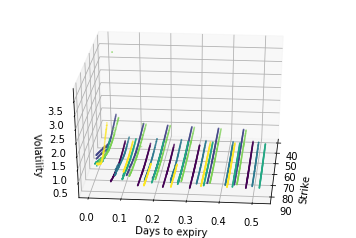

In [20]:
#%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(df["Strike"], df["Days"], df["Vol"],  
           c=df["col"],
           s=0.5
           )
ax.set_xlabel("Strike")
ax.set_ylabel("Days to expiry")
ax.set_zlabel("Volatility")
ax.view_init(30, 5)
p = plt.draw()


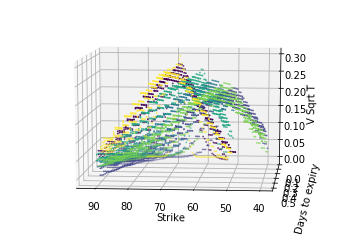

In [14]:
%matplotlib inline
greek = "V Sqrt T"
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(df["Strike"], df["Days"], df[greek],  
           c=df["col"],
           s=0.5
           )
ax.set_xlabel("Strike")
ax.set_ylabel("Days to expiry")
ax.set_zlabel(greek)
ax.view_init(10, 95)
plt.draw()
